In [1]:
##Import the required packages
import os
import keras
from keras.applications import vgg19
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.linalg import null_space
import mosek
import cvxpy as cp


Using TensorFlow backend.


In [2]:
class LEG_est: 
    def __init__(self,sol=None,lbd=None,sz=None): 
        self.sol = sol
        self.lbd = lbd
        self.sz = sz

In [13]:
def createMatrixD(p_size):   #Create the D-matrix
    if p_size==2 :
        temp = np.array([[1,-1,0,0],[1,0,-1,0],[0,1,0,-1],[0,0,1,-1]])
        return(temp)
    else:
        temp = createMatrixD(p_size-1)
    
    for i in range(1,p_size):
        temp = np.insert(temp,i*p_size-1,0, axis = 1) 
    att1_r = temp.shape[0]
    att1 = np.zeros((att1_r,p_size))
    temp = np.hstack((temp,att1))
    att2 = np.zeros((4*(p_size-1),p_size*p_size))
    for i in range(1,p_size):
        att2[4*i-4,(i*p_size-2,i*p_size-1)] = [1,-1]
        att2[4*i-3,(i*p_size-1,(i+1)*p_size-1)] = [1,-1]
        att2[4*i-2,(p_size*(p_size-2)+i-1,p_size*(p_size-1)+i-1)] = [1,-1]
        att2[4*i-1,(p_size*(p_size-1)+i-1,p_size*(p_size-1)+i)] = [1,-1]
    temp = np.vstack((temp,att2))
    return(temp)

def createSigma(matrixD):   #Create the Sigma Matrix 
    u, s, vh = np.linalg.svd(matrixD, full_matrices=True)
    numP2 = D.shape[1]
    rankD = np.linalg.matrix_rank(matrixD) 
    end = u.shape[1]
    U2 = u[:, rankD:end]
    The_space = null_space(U2.transpose())
    Dplus = np.linalg.pinv(matrixD)
    my_eig = The_space.transpose().dot(Dplus.transpose())
    temp1 = np.vstack((my_eig,np.ones((1,numP2))))
    Sigma = temp1.transpose().dot(temp1).transpose()
    return(Dplus,Sigma)

def my_conv(input_conv, size , channel):  ##Convolution input size from a*b*3 into a/s * b/s *3 and compress into one channel if channel=-1
    length,width,data_channel = input_conv.shape
    new_length = int(length/size)
    new_width = int(width/size)
    new_input  =  np.zeros((new_length,new_width))
    if channel == -1:
        for i in range(0,new_length):
            for j in range(0,new_width):
                new_input[i,j] = np.mean(input_conv[i*size:((i+1)*size),j*size:((j+1)*size),:])     
    else:
        for i in range(0,new_length):
            for j in range(0,new_width):
                new_input[i,j] = np.mean(input_conv[i*size:((i+1)*size),j*size:((j+1)*size),channel])     
    return(new_input)

def my_2ddeconv(input_conv, size):   #Deconvolution function 
    length,width = input_conv.shape
    new_length = int(length*size)
    new_width = int(width*size)
    new_input  =  np.zeros((new_length,new_width))
    for i in range(0,new_length):
        for j in range(0,new_width):
            new_input[i,j] = input_conv[i//size, j//size]       
    return(new_input)

def createBondMatrix(p):  #Create the boundary constriants matrix.  
    what = np.zeros(p*p)
    what[1:p-1] = 1 
    what[0:p*(p-1)+1:p]  =  1
    what[p-1:p*p:p] = 1
    what[p*(p-1)+1:p*p-1] = 1
    
    wow = np.zeros((4*(p-1),p*p))
    cloc = 0
    for i in range(p*p):
        if what[i] == 1:
            wow[cloc,i] = 1
            cloc +=1
    return(wow)

def makeitnoisy2(input_x,Sigma,smooth,channel_index):   ##Perturbation on images
    normal_noise = np.random.multivariate_normal(np.zeros(L*L), Sigma, 1).reshape(L,L)
    noisyimg = np.zeros((224,224,3))
    C = int(224/L)
    if channel_index == -1:
        for i in range(0,L):
            for j in range(0,L):
                noisyimg[C*i:C*i+C-1,C*j:C*j+C-1,:] = normal_noise[i,j]
    else:
        for i in range(0,L):
            for j in range(0,L):
                noisyimg[C*i:C*i+C-1,C*j:C*j+C-1,channel_index] = normal_noise[i,j]
    noisyimg1 = np.maximum(np.minimum(input_x/255.0+noisyimg,1),0)
    noisyimg2 = np.maximum(np.minimum(input_x/255.0-noisyimg,1),0)
    ###Which is the border changes.......
    if (smooth == True):
        noisyimg11 = my_conv(noisyimg1,int(224/L),channel_index)
        for i in range(1,L-1):
            noisyimg11[0,i] = noisyimg11[1,i]
            noisyimg11[L-1,i] = noisyimg11[L-2,i]
            noisyimg11[i,0] = noisyimg11[i,1]
            noisyimg11[i,L-1] = noisyimg11[i,L-2]
        noisyimg11[0,0] = noisyimg11[1,1]
        noisyimg11[L-1,L-1] = noisyimg11[L-2,L-2]
        noisyimg11[0,L-1] = noisyimg11[1,L-2]
        noisyimg11[L-1,0] = noisyimg11[L-2,1]      
        noisyimg100 = noisyimg1.copy()
        if channel_index == -1:
            for k in range(3):
                noisyimg100[:,:,k] = my_2ddeconv(noisyimg11, 8)
            noisyimg100[C:(224-C),C:(224-C),:] = noisyimg1[C:(224-C),C:(224-C),:]
        else:
            noisyimg100 = noisyimg1
            noisyimg100[:,:,channel_index] = my_2ddeconv(noisyimg11, C)
  
        noisyimg21 = my_conv(noisyimg2,8,channel_index)
        for i in range(1,L-1):
            noisyimg21[0,i] = noisyimg21[1,i]
            noisyimg21[L-1,i] = noisyimg21[L-2,i]
            noisyimg21[i,0] = noisyimg21[i,1]
            noisyimg21[i,L-1] = noisyimg21[i,L-2]
        noisyimg21[0,0] = noisyimg21[1,1]
        noisyimg21[L-1,L-1] = noisyimg21[L-2,L-2]
        noisyimg21[0,L-1] = noisyimg21[1,L-2]
        noisyimg21[L-1,0] = noisyimg21[L-2,1]      
        noisyimg200 = noisyimg2.copy()
        if channel_index == -1:
            for k in range(3):
                noisyimg200[:,:,k] = my_2ddeconv(noisyimg21, L)
            noisyimg200[C:224-C,C:224-C,:] = noisyimg2[C:224-C,C:224-C,:]
        else:
            noisyimg200 = noisyimg2
            noisyimg200[:,:,channel_index] = my_2ddeconv(noisyimg21, L)
        return(noisyimg100,noisyimg200)

    return(noisyimg1,noisyimg2)
def LEG_Solver(DS_mat,DY_mat , th1):   #Given DSmat,DYmat and threshold, calculate LEG
    x2 = cp.Variable(shape=(L*L))
    obj = cp.Minimize(cp.sum(cp.abs(D*x2))+0.01*cp.sum_squares(D*x2))
    constraint = [cp.max(cp.abs(DY_mat-DS_mat*x2)) <= th1]
    prob = cp.Problem(obj, constraint)
    prob.solve(verbose=False, solver=cp.MOSEK)
    heatmap = np.array(x2.value).reshape(L,L)
    return(heatmap)

def compute_Y(model,sampling_size,input_x,Sigma,channel):
    printProgressBar(0, sampling_size, prefix = 'Progress:', suffix = 'Complete', length = 50)
    Y = np.zeros((224,224,3))
    model_y = np.zeros((sampling_size,1))
    model_x = np.zeros((sampling_size,L*L))
    ori = input_x.copy()
    ori = np.expand_dims(ori,axis=0)
    ori = vgg19.preprocess_input(ori)
    ori_preds = model.predict(ori)
    a = ori_preds[0,chosen_class]
    for i in range(0,sampling_size,2):
        perturb_img, perturb_img2 = makeitnoisy2(input_x,Sigma,False,channel )
        rand_new = input_x/255.0 - perturb_img.copy()
        perturb_img = np.expand_dims(perturb_img,axis=0)
        perturb_img = vgg19.preprocess_input(perturb_img*255)
        preds = model.predict(perturb_img)
        b = preds[0,chosen_class]
        temp_model_f = b - a   
        model_y[i,0] = temp_model_f  
        model_x[i,:] = my_conv(rand_new,C,-1).flatten()
        Y += 1/sampling_size*temp_model_f*(-rand_new)

        rand_new = input_x/255.0 - perturb_img2.copy()
        perturb_img2 = np.expand_dims(perturb_img2,axis=0)
        perturb_img2 = vgg19.preprocess_input(perturb_img2*255)
        preds = model.predict(perturb_img2)
        b = preds[0,chosen_class]
        temp_model_f = b - a
        
        model_y[i+1,0] = temp_model_f  
        model_x[i+1,:] = my_conv(rand_new,C,-1).flatten()
        Y += 1/sampling_size*temp_model_f*(-rand_new)
    return(model_x,model_y,Y)


def generateHeatmap(image,ht,name,style,showOption=True, direction="all"):
    result_path = "Result" 
    dest = os.path.join(result_path,name)
    ht_print = ht.copy()
    if direction =="positive":
        ht_print[ht_print<0] = 0
    if direction =="negative":
        ht_print = -ht_print
        ht_print[ht_print<0] = 0
    if style == "heatmap_only":
        plt.imshow(ht_print,cmap='hot',interpolation='nearest')
        plt.colorbar()
        #plt.title(name)
        plt.savefig(dest)
    if style == "gray":    
        gray = rgb2gray(image/255.0)    
        plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
        plt.imshow(ht_print, cmap='gist_gray', interpolation='nearest', alpha=0.8)
        plt.colorbar()
        #plt.title(name)
        plt.savefig(dest)
    if showOption == True:
        plt.show()
        
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()
        
        
def rgb2gray(rgb):  #turn rbg to gray scale
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])



def LEG_Explain(vgg_model, image0, image_name , noise_lvl , lambda_lvl,sampling_size,conv):
    global D,D_ex,Dplus,Sigma_init,Dplus_t,L,C
    resultList = []
    C = conv
    L = int(224/conv)
    noise_len = len(noise_lvl)
    lambda_len = len(lambda_lvl)
    D = createMatrixD(L)
    D_ex = createBondMatrix(L)
    D = np.vstack((D,D_ex))
    Dplus, Sigma_init = createSigma(D)
    Dplus_t = Dplus.transpose()

    lambda_len = len(lambda_lvl)
    noise_len = len(noise_lvl)
    for i in range(0,noise_len):
        Sigma = Sigma_init.copy()
        Sigma=Sigma*noise_lvl[i]**2
        DS_mat = np.matmul(Dplus_t,Sigma)
        model_x0,model_y0,Result_Ori0 = compute_Y(vgg_model,sampling_size,image0,Sigma,0)
        y_vec0 = my_conv(Result_Ori0,conv,-1)
        y_vec_try = my_conv(Result_Ori0,conv,0)
        y_vec0 = y_vec0.flatten()
        DY_mat0 = np.matmul(Dplus_t,y_vec0)
        
        model_x1,model_y1,Result_Ori1 = compute_Y(vgg_model,sampling_size,image0,Sigma,1)
        y_vec1 = my_conv(Result_Ori1,conv,-1)
        y_vec1 = y_vec1.flatten()
        DY_mat1 = np.matmul(Dplus_t,y_vec1)
        
        model_x2,model_y2,Result_Ori2 = compute_Y(vgg_model,sampling_size,image0,Sigma,2)
        y_vec2 = my_conv(Result_Ori2,conv,-1)
        y_vec2 = y_vec2.flatten()
        DY_mat2 = np.matmul(Dplus_t,y_vec2)
        
        
        for j in range(0, lambda_len):
            ref0 = np.max(np.abs(DY_mat0))
            th0 = float(ref0*lambda_lvl[j])
            ht0 = LEG_Solver(DS_mat,DY_mat0, th0)
            ref1 = np.max(np.abs(DY_mat1))
            th1 = float(ref1*lambda_lvl[j])
            ht1 = LEG_Solver(DS_mat,DY_mat1, th1)
            ref2 = np.max(np.abs(DY_mat2))
            th2 = float(ref2*lambda_lvl[j])
            ht2 = LEG_Solver(DS_mat,DY_mat2, th2)
                     
            ht = abs(ht0)+abs(ht1)+abs(ht2)
            resultList.append(LEG_est(my_2ddeconv(ht,conv),lambda_lvl[j],noise_lvl[i]))
            printProgressBar(i*(j+1)+j+1, lambda_len*noise_len, prefix = 'Progress:', suffix = 'Complete', length = 50)
    return(resultList)




In [4]:
noise_lvl  = np.array([0.1])
lambda_lvl = np.array([0.013])
  

image_folder = "Image"
filename = "balloon"
vgg_model = vgg19.VGG19(include_top =True)

image0 = image.load_img(os.path.join(image_folder,filename+'.jpg'), target_size=(224,224))
image0 = image.img_to_array(image0)
image_input = np.expand_dims(image0.copy(),axis=0)
image_input = vgg19.preprocess_input(image_input)
preds = vgg_model.predict(image_input)
for x in decode_predictions(preds)[0]:
    print(x)
chosen_class = np.argmax(preds)        

task = LEG_Explain(vgg_model, image0, filename , noise_lvl , lambda_lvl ,sampling_size = 2000, conv = 8)
#generateHeatmap(image0,ht,filename3,style = "heatmap_only")
#generateHeatmap(image0,ht,filename0,style = "gray",direction = "positive")
#generateHeatmap(image0,ht,filename1,style = "gray",direction = "negative")
#generateHeatmap(image0,ht,filename2,style = "gray",direction = "all")

Instructions for updating:
Colocations handled automatically by placer.
('n02782093', 'balloon', 0.9998578)
('n02692877', 'airship', 0.00011602313)
('n04562935', 'water_tower', 1.8518946e-05)
('n03888257', 'parachute', 4.7791104e-06)
('n03956157', 'planetarium', 1.7507913e-06)
Progress: |██████████████████████████████████████████████████| 100.0% Complete


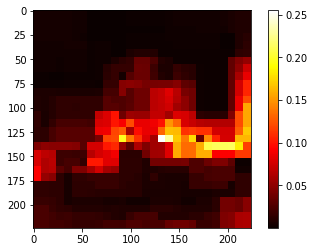

In [14]:
generateHeatmap(image0,task[0].sol,name="test.jpg",style = "heatmap_only")